#  BlueSTARR-predicted effects of mutation vs Kircher _et al_ 2019

We assess the accuracy of BlueSTARR model predictions by comparing its predicted effects of mutations to those generated experimentally through saturation mutagenesis via MPRA assays in [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w).

Specifically, we'll map the coordinates to genomic positions we have BlueSTARR predictions for, and then look at scatter plots as well as an AUROC analysis.

## Setup

### Imports

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import duckdb
from pathlib import Path

### Paths to data and databases

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MUT_PRED_DB = DB_ROOT / 'cCRE-preds-K562'
MUT_PRED_INFILL_DB = DB_ROOT / 'Kircher-2019_infill.parquet'
DATA_DIR = PROJECT_ROOT / 'benchmarks' / 'Kircher_et_al_2019'

## Load Kircher _et al_ (2019) data files

The columns in the files are the following (according to, and taken verbatim from, the [wiki accompanying the file deposition](https://osf.io/75b2m/wiki/Files/)):
1. **Chromosome** - Chromosome of the variant.
2. **Position** - Chromosomal position (GRCh38 or GRCh37) of the variant. _(We are using the GRCh38 coordinates)_
3. **Ref** - Reference allele of the variant (A, T, G, or C).
4. **Alt** - Alternative allele of the variant (A, T, G, or C). One base-pair deletions are represented as -.
5. **Tags** - Number of unique tags associated with the variant.
6. **DNA** - Count of DNA sequences that contain the variant (used for fitting the linear model).
7. **RNA** - Count of RNA sequences that contain the variant (used for fitting the linear model).
8. **Value** - Log2 variant expression effect derived from the fit of the linear model (coefficient).
9. **P-Value** - P-value of the coefficient.

In [3]:
mut_data = pl.scan_csv(DATA_DIR / "*" / "*.tsv", separator="\t",
                       has_header=True, null_values=["NA"], include_file_paths="file_path")

For parsing the file paths, the directory indicates the type of region (_enhancer_ or _promoter_, with the UCE being lumped in with enhancers). The filenames (i.e., base names) themselves have a prefix signifying the genome assembly version, the file extension as a suffix, and the part in between being the experiment. Most experiments correspond 1:1 to regions, but some include replicates, reverse strand, different protocols (time of harvesting, for example), etc. It appears that designations of replicate, protocol, etc are appended following either a dot or a dash.

In [4]:
mut_data = mut_data.filter(
    pl.col('Ref').str.len_bytes() == 1,
    pl.col('Alt').str.len_bytes() == 1,
    pl.col('Alt') != '-',
).with_columns(
    pl.col('Position').add(-1).alias('allele_pos'),
    (pl.lit('chr') + pl.col('Chromosome')).alias('chrom'),
    pl.col('Ref').alias('ref_allele'),
    pl.col('Alt').alias('alt_allele'),
    pl.col('P-Value').alias('p_value'),
    pl.col('file_path').str.extract(r'GRCh38_(.*).tsv$').alias('experiment'),
    pl.col('file_path').str.split('/').list.get(-2).alias('region_type')
).with_columns(
    pl.col('experiment').str.extract(r'^([^-.]+)').alias('region'),
).drop(['Ref', 'Alt', 'Position', 'Chromosome']).drop_nulls()

In [5]:
kircher_ntotal = len(mut_data.select(['chrom']).collect())
kircher_nmut = len(mut_data.select(['chrom', 'allele_pos', 'alt_allele']).unique().collect())
print(f"Total number of MPRA results: {kircher_ntotal:,}")
print(f"Total number of mutations with MPRA results: {kircher_nmut:,}")

Total number of MPRA results: 39,170
Total number of mutations with MPRA results: 29,444


## Merge with BlueSTARR mutation predictions

### Database with BlueSTARR predictions from saturated mutagenesis of cCREs

In [6]:
mutpreds = duckdb.read_parquet(str(DB_ROOT / f'{MUT_PRED_DB}/**/*.parquet'), hive_partitioning=True)
print(f"Predictions from cCREs: {mutpreds.count('chrom').fetchall()[0][0]:,}")

Predictions from cCREs: 816,826,569


In [7]:
mutpreds_infill = duckdb.read_parquet(str(MUT_PRED_INFILL_DB))
print(f"Predictions from infill: {mutpreds_infill.count('chrom').fetchall()[0][0]:,}")

Predictions from infill: 13,701


### Join by chromosomal position and alternative allele

We include the reference allele as a sanity check. Including it in the join conditions in theory would be redundant with joining by chromosomal position. By omitting it from the join conditions, we can check that indeed the reference alleles are the same from both tables.

Kircher _et al_ (2019) use not only the effect size, but also the P-value and Tags columns for filtering. We therefore include both here.

In [8]:
blue_kircher = duckdb.sql(
    "select k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, "
    "m.ref_allele as blue_ref_allele, m.log2FC, "
    "last(k.Value order by abs(k.Value)) as mpra_max_log2effect, "
    "last(k.p_value order by abs(k.Value)) as mpra_p_value, "
    "last(k.Tags order by abs(k.Value)) as mpra_tags "
    "from mut_data k, mutpreds m "
    "where k.chrom = m.chrom "
    "and k.allele_pos = m.allele_pos and k.alt_allele = m.allele "
    "group by k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, m.ref_allele, m.log2FC")

It's not necessary for the ROC curve analysis, but to make sanity inspection easier we order by chromosomal position and alt allele. 

In [9]:
bk_df = blue_kircher.df().sort_values(['chrom', 'allele_pos', 'alt_allele'])
print(f"Number of MPRA results matching cCRE predictions: {len(bk_df):,}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of MPRA results matching cCRE predictions: 15,820


In [10]:
infill_data = duckdb.sql(
    "select k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, "
    "m.ref_allele as blue_ref_allele, m.log2FC, "
    "last(k.Value order by abs(k.Value)) as mpra_max_log2effect, "
    "last(k.p_value order by abs(k.Value)) as mpra_p_value, "
    "last(k.Tags order by abs(k.Value)) as mpra_tags "
    "from mut_data k, mutpreds_infill m "
    "where k.chrom = m.chrom "
    "and k.allele_pos = m.allele_pos and k.alt_allele = m.allele "
    "group by k.region_type, k.region, k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, m.ref_allele, m.log2FC")
print(f"Number of MPRA results matching infill predictions: {infill_data.count('chrom').fetchall()[0][0]:,}")

Number of MPRA results matching infill predictions: 13,648


In [11]:
bk_infill = duckdb.sql(
    "select * from infill_data bki where not exists ("
    "select 1 from blue_kircher bk "
    "where bk.chrom = bki.chrom and bk.allele_pos = bki.allele_pos and bk.alt_allele = bki.alt_allele)").df()
print(f"Number of MPRA results matching infill predictions but not cCRE predictions: {len(bk_infill):,}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of MPRA results matching infill predictions but not cCRE predictions: 13,624


In [12]:
bk_df = pd.concat([bk_df, bk_infill], ignore_index=True).sort_values(['chrom', 'allele_pos', 'alt_allele'])

In [13]:
print(f"Number of MPRA results matched with BlueSTARR predictions: {len(bk_df):,} ({len(bk_df)/kircher_nmut:.1%} of mutations)")

Number of MPRA results matched with BlueSTARR predictions: 29,444 (100.0% of mutations)


Sanity check: for every position, the reference alleles between Kircher _et al_ and BlueSTARR should be the same.

In [14]:
bk_df.loc[bk_df['ref_allele'] != bk_df['blue_ref_allele']]

,region_type,region,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags


### Write matched table to file

In [15]:
# bk_df.to_csv(DB_ROOT / 'blue_kircher.csv.gz', index=False)

### Inspect Kircher's MPRA effect sizes and BlueSTARR predictions

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

We'll look at BlueSTARR predictions vs MPRA effect sizes over the entire range of p-values. However, we exclude rows with Tags < 10 (as Kircher _et al_ (2019) do), and we color based on $\log_{10}$ of p-values so we get a better sense of the range.

In [17]:
bk_df['mpra_log10_pval'] = np.log10(bk_df['mpra_p_value']+1e-20)

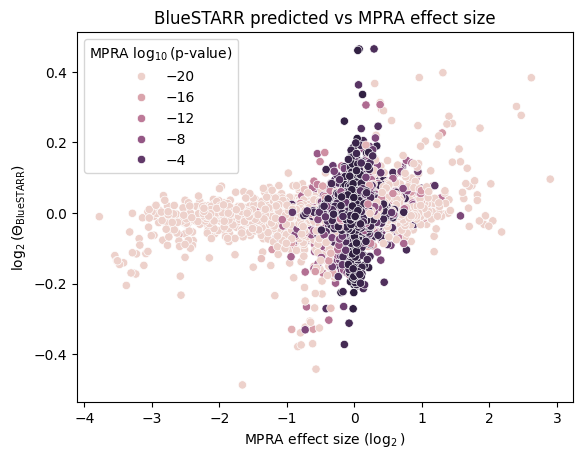

In [18]:
ax = sns.scatterplot(data=bk_df.loc[bk_df['mpra_tags'] >= 10],
                     x='mpra_max_log2effect', y='log2FC',
                     hue='mpra_log10_pval')
ax.set(xlabel='MPRA effect size ($\log_2)$', ylabel='$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
ax.set_title('BlueSTARR predicted vs MPRA effect size')
ax.legend(title='MPRA $\log_{10}$(p-value)')

## ROC display and AUC

### Define positive and negative classes

We define the positive class as variants with $P_{reg}$ greater than some threshold, and the negative class as variants with $P_{reg}$ less than some threshold.

In [19]:
Pval_pos = 1e-5
Pval_neg = 0.01
effect_neg = 0.05

For labeling classes, require a minimum Tag count of 10, as recommended in Kircher _et al_ (2019), and similarly for the negative class cut off absolute effect size at 0.05. (Strictly speaking, Kircher _et al_ only give _"$log_2$ expression effect < 0.05"_, but we assume they meant _absolute_ expression effect.)

In [20]:
pos_label = f"MPRA p<{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"
bk_df['label'] = None
bk_df.loc[(bk_df['mpra_p_value'] < Pval_pos) &
          (bk_df['mpra_tags'] >= 10), 'label'] = pos_label 
bk_df.loc[(bk_df['mpra_p_value'] > Pval_neg) &
          (bk_df['mpra_max_log2effect'].abs() < 0.05) &
          (bk_df['mpra_tags'] >= 10), 'label'] = neg_label

### Subset predictions into those with positive and negative effects

We also create a set of all effects (regardless of direction) suitable for ROC analysis, which means we use the absolute predicted effect in $\log_2$ space.

In [21]:
bk_df_pos = bk_df.loc[bk_df['label'].notna() & (bk_df['mpra_max_log2effect'] >= 0)]
bk_df_neg = bk_df.loc[bk_df['label'].notna() & (bk_df['mpra_max_log2effect'] < 0)]
bk_df['abs_log2FC'] = bk_df['log2FC'].abs()
bk_df_all = bk_df.loc[bk_df['label'].notna()]

How many positives and negatives do we have?

In [22]:
bk_df_pos.value_counts('label')

label
MPRA p>0.01     5791
MPRA p<1e-05    1804
Name: count, dtype: int64

In [23]:
bk_df_neg.value_counts('label')

label
MPRA p>0.01     4667
MPRA p<1e-05    2953
Name: count, dtype: int64

In [24]:
bk_df_all.value_counts('label')

label
MPRA p>0.01     10458
MPRA p<1e-05     4757
Name: count, dtype: int64

Text(0.5, 1.0, 'BlueSTARR predicted vs MPRA effect size')

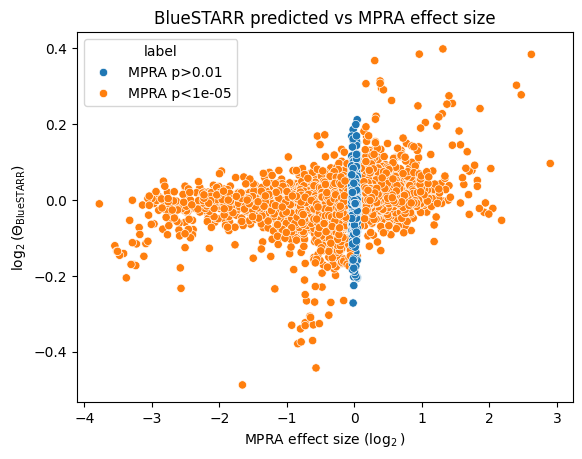

In [25]:
ax = sns.scatterplot(data=bk_df_all,
                     x='mpra_max_log2effect', y='log2FC',
                     hue='label')
ax.set(xlabel='MPRA effect size ($\log_2)$', ylabel='$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
ax.set_title('BlueSTARR predicted vs MPRA effect size')

### ROC curve display and AUC calculation


In [26]:
from sklearn.metrics import RocCurveDisplay, roc_curve, matthews_corrcoef

Text(0.5, 1.0, 'BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)')

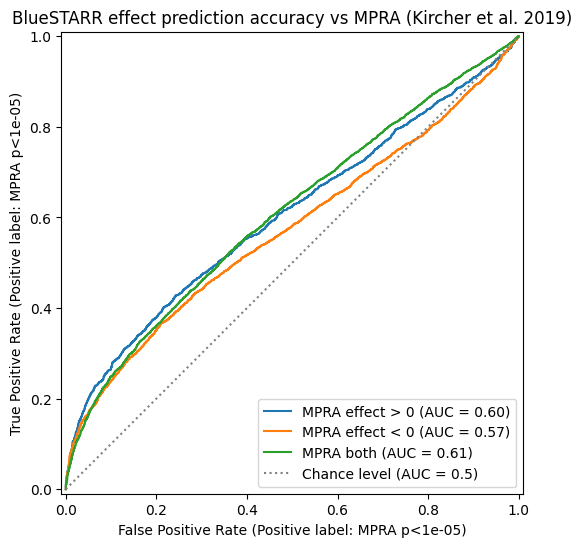

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_pos = RocCurveDisplay.from_predictions(
    bk_df_pos['label'],
    bk_df_pos['log2FC'], pos_label=pos_label,
    name='MPRA effect > 0', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bk_df_neg['label'],
    -bk_df_neg['log2FC'], pos_label=pos_label,
    name='MPRA effect < 0', ax=ax)
roc_all = RocCurveDisplay.from_predictions(
    bk_df_all['label'],
    bk_df_all['abs_log2FC'], pos_label=pos_label,
    name='MPRA both', ax=ax,
    plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
ax.set_title('BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)')


#### ROC curve and AUROC as per Kircher _et al_ (2019)

Kircher _et al_ in Supplementary Table 17 give AUC scores for a variety of classifiers, but in addition to the filtering (Tags >= 10; P<1e-5 for TPs; P>1e-5 and $\log_2$(expression effect) < 0.05 for TNs) their ROC computation uses only the top _N_, with $N \in \{200, 500, 1000\}$, variants with "highest expression effect", which we assume to be the absolute expression effect size in $\log_2$ space.

We repeat this way of subsetting the data here, too.

In [28]:
def topN_dataset(df, neg_label, N=1000, random_state=42):
    topN = df['mpra_max_log2effect'].abs().argsort()[-N:]
    return pd.concat([df.iloc[topN],
                      df.loc[df['label'] == neg_label].sample(N, random_state=random_state)],
                      ignore_index=True)

In [29]:
def roc_topN(df, neg_label, Ns=[1000,500,200], ax=None, include_full=True, print_precise=True, random_state=42):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    rocs = {}
    if include_full:
        roc = RocCurveDisplay.from_predictions(
            df['label'],
            df['abs_log2FC'], pos_label=pos_label,
            name='MPRA all', ax=ax)
        rocs['All'] = roc
    df_topNs = {N: topN_dataset(df, neg_label=neg_label, N=N, random_state=random_state) for N in Ns}
    for N, df_topN in df_topNs.items():
        chance_level_args = dict(
            plot_chance_level=True,
            chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'}) if N == Ns[-1] else {}
        roc = RocCurveDisplay.from_predictions(
            df_topN['label'],
            df_topN['abs_log2FC'], pos_label=pos_label,
            name=f'MPRA Top-{N}', ax=ax,
            **chance_level_args)
        rocs[N] = roc
    if print_precise:
        print(f"More precise AUCs:")
        for N, roc in rocs.items():
            if type(N) == int:
                print(f"Top {N:4} = {roc.roc_auc:.3f}")
            else:
                print(f"{N} data = {roc.roc_auc:.3f}")
    return rocs, ax


##### All regions together

More precise AUCs:
All data = 0.609
Top 1000 = 0.663
Top  500 = 0.652
Top  200 = 0.643


Text(0.5, 1.0, 'BlueSTARR accuracy vs MPRA (Kircher et al. 2019)')

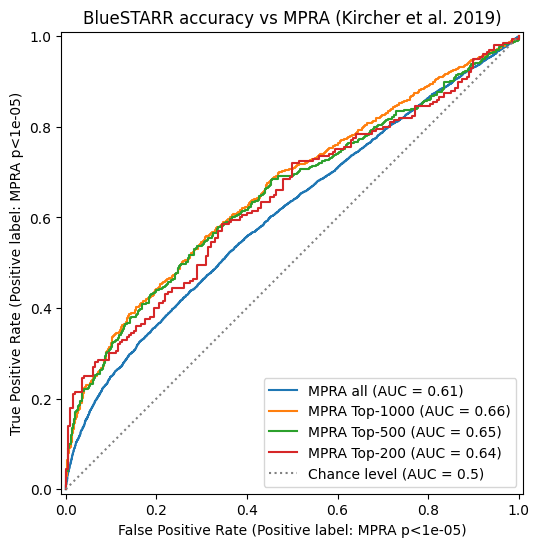

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
rocs, ax = roc_topN(bk_df_all, neg_label, ax=ax)
ax.set_title('BlueSTARR accuracy vs MPRA (Kircher et al. 2019)')


##### Enhancer and Promoter regions separated

More precise AUCs:
All data = 0.568
Top 1000 = 0.586
Top  500 = 0.579
Top  200 = 0.580


Text(0.5, 1.0, 'BlueSTARR accuracy vs MPRA: Enhancers (Kircher et al. 2019)')

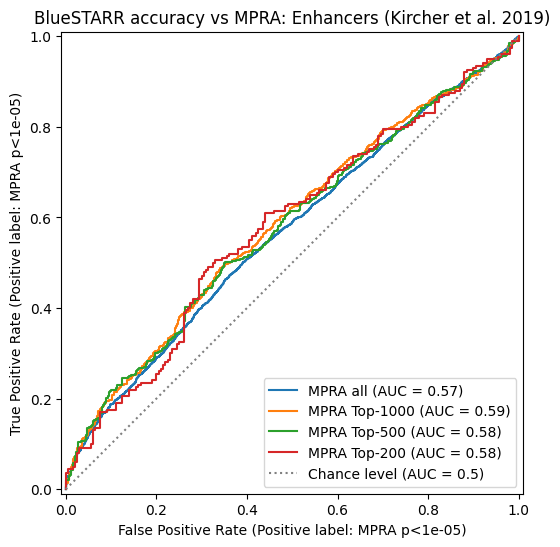

In [31]:
enh_df = bk_df_all.loc[bk_df_all['region_type'] == 'Enhancers']
fig, ax = plt.subplots(figsize=(6, 6))
rocs_enh, ax = roc_topN(enh_df, neg_label, ax=ax)
ax.set_title('BlueSTARR accuracy vs MPRA: Enhancers (Kircher et al. 2019)')

More precise AUCs:
All data = 0.664
Top 1000 = 0.724
Top  500 = 0.740
Top  200 = 0.749


Text(0.5, 1.0, 'BlueSTARR accuracy vs MPRA: Promoters (Kircher et al. 2019)')

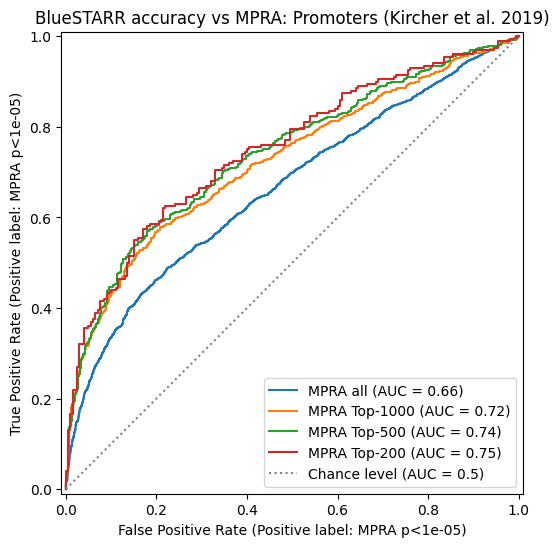

In [32]:
prom_df = bk_df_all.loc[bk_df_all['region_type'] == 'Promoters']
fig, ax = plt.subplots(figsize=(6, 6))
rocs_prom, ax = roc_topN(prom_df, neg_label, ax=ax)
ax.set_title('BlueSTARR accuracy vs MPRA: Promoters (Kircher et al. 2019)')

### Matthew's Correlation Coefficient

The [Matthew's Correlation Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) (MCC), also known as Phi Coefficient, seems to be used in quite a few papers for reporting peformance against a benchmark.

To compute this, we need to decide on a decision boundary for the BlueSTARR predictions. We will determine the decision boundaries for the positive and negative effects, respectively, from [Youden's J statistic](https://en.wikipedia.org/wiki/Youden's_J_statistic) to find the threshold that maximizes the difference between TPR and FPR.

In [33]:
fpr_pos, tpr_pos, thresh_pos = roc_curve(bk_df_pos['label'], bk_df_pos['log2FC'], pos_label=pos_label)
fpr_neg, tpr_neg, thresh_neg = roc_curve(bk_df_neg['label'], -bk_df_neg['log2FC'], pos_label=pos_label)
fpr_all, tpr_all, thresh_all = roc_curve(bk_df_all['label'], bk_df_all['abs_log2FC'], pos_label=pos_label)

In [34]:
cutoffs = {
    'pos_cutoff': thresh_pos[np.argmax(tpr_pos - fpr_pos)],
    'neg_cutoff': -thresh_neg[np.argmax(tpr_neg - fpr_neg)],
    'all_cutoff': thresh_all[np.argmax(tpr_all - fpr_all)],
}
cutoffs

{'pos_cutoff': 0.016852192907375996,
 'neg_cutoff': -0.015177858750721918,
 'all_cutoff': 0.022493346921508006}

In [35]:
mccs = {
    'MPRA effect > 0': matthews_corrcoef(bk_df_pos['label'] == pos_label,
                                         bk_df_pos['log2FC'] >= cutoffs['pos_cutoff']),
    'MPRA effect < 0': matthews_corrcoef(bk_df_neg['label'] == pos_label,
                                         bk_df_neg['log2FC'] <= cutoffs['neg_cutoff']),
    'MPRA full': matthews_corrcoef(bk_df_all['label'] == pos_label,
                                   bk_df_all['abs_log2FC'] >= cutoffs['all_cutoff']),
}
for label, mcc in mccs.items():
    print(f"MCC ({label}): {mcc:.3f}")

MCC (MPRA effect > 0): 0.180
MCC (MPRA effect < 0): 0.171
MCC (MPRA full): 0.165
